# Keras Regression Project for Seattle House Price Prediction

This notebook uses Artificial Neural Network to predict the price of house in Seattle state. The dataset is chosen from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction)
  
Quick description on the columns of the dataset:  
- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
house_df = pd.read_csv('../DATA/kc_house_data.csv')

In [3]:
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Data Cleaning

Let's look at the dataset for missing values. Let's also check for outliers in the dataset

In [4]:
house_df.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

As the dataset has no null values, lets check for outliers by visualization

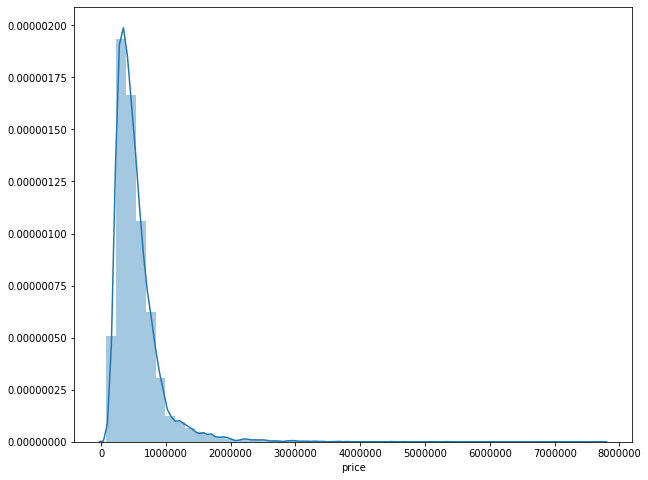

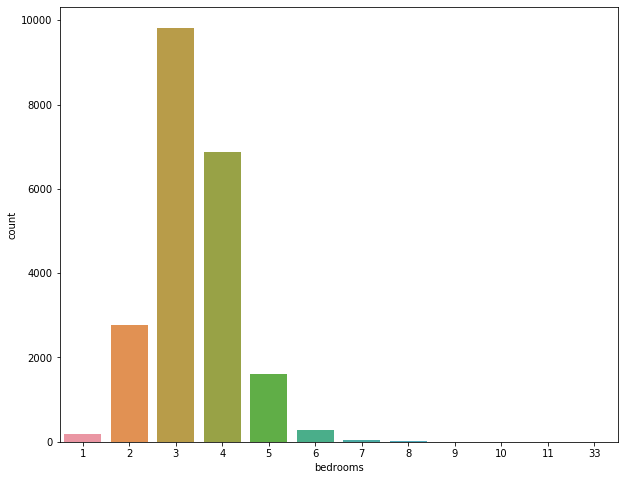

In [5]:
# Plotting the target variable

plt.rcParams['figure.figsize'] = (10,8)
sns.distplot(house_df['price'])
plt.show()
sns.countplot(house_df['bedrooms'])

##### Insights:
    - As seen from the two figures, the density of price is between 0 and 3000000 while that of bedrooms is between 2 and 5.
    - There exists a house with a bedroom of 33 (kind of mansion), also very few houses are in the range of 7000000 or 8000000. If the application is focussed on finding the mid-range housing sales then the above values becomes the outliers...

### EDA

Let's look in the behaviour of each column with respect to target

In [6]:
house_df.corr()['price'].sort_values(ascending = False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.397370
sqft_basement    0.323799
bedrooms         0.308787
lat              0.306692
waterfront       0.266398
floors           0.256804
yr_renovated     0.126424
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

sqft_living, bathrooms, bedrooms, view has positive correlation wrt price. Since the lat has some positive correlation wrt price, lets visualize it by checking the geographical coordinates. This is how the area looks like in Google Maps.  
  
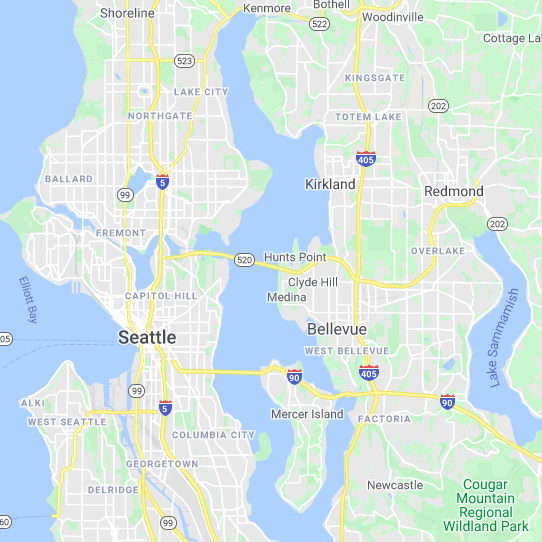

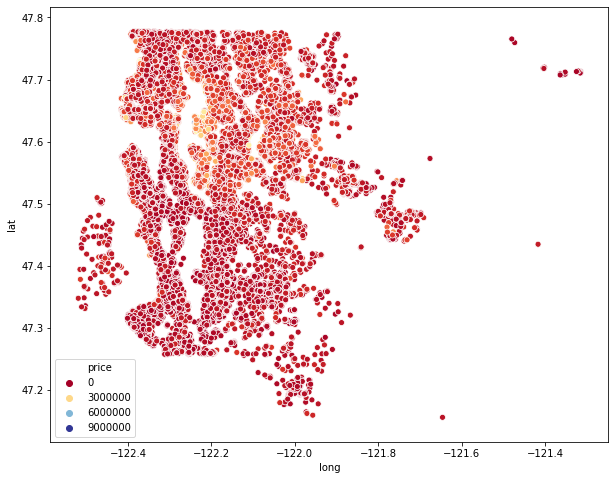

In [7]:
sns.scatterplot(x = 'long',y = 'lat',data = house_df, palette = 'RdYlBu', hue = 'price')

It's not that clear on the density of houses and their pricing. It might be due to the outliers present (very expensive houses). Let's try to remove the top 1% of the houses from the given df and try it out again...

In [8]:
len(house_df)*(0.01) # we will loose around 216 houses which are mostly outliers

215.97

In [9]:
df = house_df.sort_values('price', ascending = False).iloc[216:] 

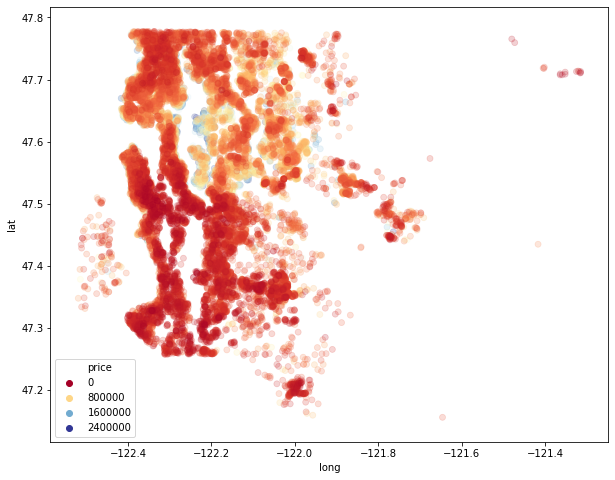

In [10]:
sns.scatterplot(x = 'long',y = 'lat', data = df, hue = 'price', palette = 'RdYlBu', edgecolor = None, alpha = 0.2)

Looking at the Google Maps image and comparing the above plot, waterfront houses are the most expensive ones!

### Feature Engineering

In [11]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6329,824059321,6/2/2014,1970000.0,4,3.50,4370,8510,2.0,0,1,...,10,3610,760,2003,0,98004,47.5876,-122.204,2960,10347
12271,1923000260,10/15/2014,1960000.0,5,4.50,6200,23373,3.0,0,1,...,11,5050,1150,1988,0,98040,47.5632,-122.215,3700,14486
9166,3124059023,2/13/2015,1960000.0,3,1.75,3330,12566,1.0,1,4,...,8,1940,1390,1960,0,98040,47.5287,-122.220,3730,16560
12565,2806300065,4/22/2015,1960000.0,4,4.00,4430,31353,2.0,0,0,...,12,4430,0,1998,0,98005,47.6422,-122.157,3900,35237
1150,4055701200,4/21/2015,1960000.0,4,2.75,3120,7898,1.0,1,4,...,8,1560,1560,1963,0,98034,47.7165,-122.259,2630,13868


Let's remove the unnecessary columns from the dataframe like 'id','zipcode'.

In [12]:
df.drop(['id','zipcode'], axis = 1, inplace = True)

In [13]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [14]:
df['yr_old'] = 2020 - df['yr_built'] # consider a new feature
df.drop(['yr_built'], axis = 1, inplace = True)

In [15]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,yr_old
6329,6/2/2014,1970000.0,4,3.50,4370,8510,2.0,0,1,3,10,3610,760,0,47.5876,-122.204,2960,10347,17
12271,10/15/2014,1960000.0,5,4.50,6200,23373,3.0,0,1,4,11,5050,1150,0,47.5632,-122.215,3700,14486,32
9166,2/13/2015,1960000.0,3,1.75,3330,12566,1.0,1,4,4,8,1940,1390,0,47.5287,-122.220,3730,16560,60
12565,4/22/2015,1960000.0,4,4.00,4430,31353,2.0,0,0,3,12,4430,0,0,47.6422,-122.157,3900,35237,22
1150,4/21/2015,1960000.0,4,2.75,3120,7898,1.0,1,4,4,8,1560,1560,0,47.7165,-122.259,2630,13868,57


In [16]:
df['yr_renovated'].value_counts()

0       20499
2014       91
2013       36
2007       34
2000       34
        ...  
1959        1
1954        1
1948        1
1944        1
1951        1
Name: yr_renovated, Length: 70, dtype: int64

looking at yr_renovated, around 20499 houses arent renovated at all.. This will affect the sale price.. Also if the house is recently renovated then it's price will be higher! Let's make this a binary column (renovated - 1 and not renovated-0) on the year condition!

In [17]:
def change_to_binary(yr):
    if yr >= 2000:
        return 1
    else:
        return 0

In [18]:
df['renovated_or_not'] = df['yr_renovated'].apply(change_to_binary)

df.drop(['yr_renovated'], axis = 1, inplace = True)

Let's look at the date column. let's check if the year or month affected the house sale prices...

In [19]:
df['date'] = pd.to_datetime(df['date'])

In [20]:
df['sale_yr'] = df['date'].apply(lambda date:date.year)
df['sale_month'] = df['date'].apply(lambda date:date.month)

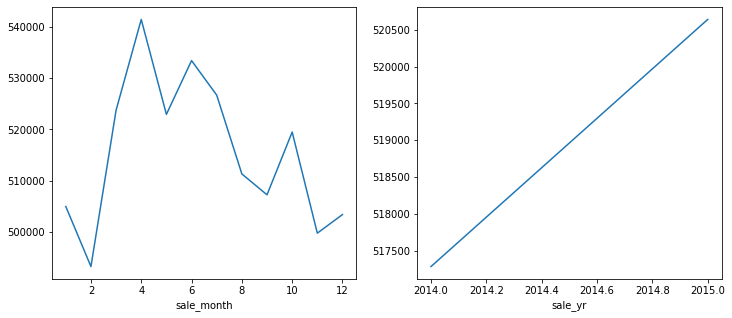

In [21]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (12,5))
df.groupby('sale_month').mean()['price'].plot(ax = ax1)
df.groupby('sale_yr').mean()['price'].plot(ax = ax2)

Month doesnt seem to have much effect on the sale of houses but Year has..

In [22]:
df.drop(['date','sale_month'], axis = 1, inplace = True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21381 entries, 6329 to 15279
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             21381 non-null  float64
 1   bedrooms          21381 non-null  int64  
 2   bathrooms         21381 non-null  float64
 3   sqft_living       21381 non-null  int64  
 4   sqft_lot          21381 non-null  int64  
 5   floors            21381 non-null  float64
 6   waterfront        21381 non-null  int64  
 7   view              21381 non-null  int64  
 8   condition         21381 non-null  int64  
 9   grade             21381 non-null  int64  
 10  sqft_above        21381 non-null  int64  
 11  sqft_basement     21381 non-null  int64  
 12  lat               21381 non-null  float64
 13  long              21381 non-null  float64
 14  sqft_living15     21381 non-null  int64  
 15  sqft_lot15        21381 non-null  int64  
 16  yr_old            21381 non-null  int

Now that all the columns are of float/int type, its time to move on to modelling!

### Feature Scaling

In [24]:
X = df.drop(['price'], axis = 1) #features
y = df['price'] #target

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [26]:
print('Training set size\n Feature: {}\n Target: {}'.format(X_train.shape, y_train.shape))
print('Testing set size\n Feature: {}\n Target: {}'.format(X_test.shape, y_test.shape))

Training set size
 Feature: (17104, 18)
 Target: (17104,)
Testing set size
 Feature: (4277, 18)
 Target: (4277,)


Let's scale the features before modelling it

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [28]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Building Regressor Model using ANN

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 

In [30]:
model = Sequential()

model.add(Dense(18, activation = 'relu')) #since we have 18 columns as input
model.add(Dense(18, activation = 'relu'))
model.add(Dense(18, activation = 'relu'))
model.add(Dense(18, activation = 'relu'))
model.add(Dense(1)) #output layer

model.compile(optimizer = 'adam',loss = 'mse')

Input layer has 18 neurons as it corresponds to 18 columns in feature vector. Since we need a regression output, last layer has only 1 neuron! Also the optimizer considered is 'Adaptive Gradient Descent' and the loss considered is 'Mean Square Error'.  
Let's fit the model using the training test and adjust the weights-bias based on the loss metric. Lets also see if the model works well on the validation test.

In [31]:
model.fit(x = X_train, y = y_train.values, validation_data = (X_test, y_test.values), batch_size = 128, epochs = 400)

Epoch 1/400
134/134 [==============================] - 1s 5ms/step - loss: 352002834432.0000 - val_loss: 341224095744.0000
Epoch 2/400
134/134 [==============================] - 0s 2ms/step - loss: 349300785152.0000 - val_loss: 331853627392.0000
Epoch 3/400
134/134 [==============================] - 0s 1ms/step - loss: 309281652736.0000 - val_loss: 249264128000.0000
Epoch 4/400
134/134 [==============================] - 0s 1ms/step - loss: 174263861248.0000 - val_loss: 107510374400.0000
Epoch 5/400
134/134 [==============================] - 0s 1ms/step - loss: 85843451904.0000 - val_loss: 74140467200.0000
Epoch 6/400
134/134 [==============================] - 0s 1ms/step - loss: 66544394240.0000 - val_loss: 62117457920.0000
Epoch 7/400
134/134 [==============================] - 0s 1ms/step - loss: 57684791296.0000 - val_loss: 55273103360.0000
Epoch 8/400
134/134 [==============================] - 0s 1ms/step - loss: 52076482560.0000 - val_loss: 50244194304.0000
Epoch 9/400
134/134 [===

134/134 [==============================] - 0s 1ms/step - loss: 20562475008.0000 - val_loss: 19950596096.0000
Epoch 69/400
134/134 [==============================] - 0s 1ms/step - loss: 20544782336.0000 - val_loss: 19891398656.0000
Epoch 70/400
134/134 [==============================] - 0s 1ms/step - loss: 20505106432.0000 - val_loss: 19851057152.0000
Epoch 71/400
134/134 [==============================] - 0s 1ms/step - loss: 20483131392.0000 - val_loss: 19827091456.0000
Epoch 72/400
134/134 [==============================] - 0s 1ms/step - loss: 20451049472.0000 - val_loss: 19814494208.0000
Epoch 73/400
134/134 [==============================] - 0s 1ms/step - loss: 20437915648.0000 - val_loss: 19796959232.0000
Epoch 74/400
134/134 [==============================] - 0s 1ms/step - loss: 20396943360.0000 - val_loss: 19784204288.0000
Epoch 75/400
134/134 [==============================] - 0s 1ms/step - loss: 20385939456.0000 - val_loss: 19739719680.0000
Epoch 76/400
134/134 [===============

Epoch 135/400
134/134 [==============================] - 0s 1ms/step - loss: 19404793856.0000 - val_loss: 19019886592.0000
Epoch 136/400
134/134 [==============================] - 0s 1ms/step - loss: 19392106496.0000 - val_loss: 18993315840.0000
Epoch 137/400
134/134 [==============================] - 0s 1ms/step - loss: 19387011072.0000 - val_loss: 19001657344.0000
Epoch 138/400
134/134 [==============================] - 0s 1ms/step - loss: 19376687104.0000 - val_loss: 18975811584.0000
Epoch 139/400
134/134 [==============================] - 0s 1ms/step - loss: 19377958912.0000 - val_loss: 18974107648.0000
Epoch 140/400
134/134 [==============================] - 0s 1ms/step - loss: 19361802240.0000 - val_loss: 18971756544.0000
Epoch 141/400
134/134 [==============================] - 0s 1ms/step - loss: 19353612288.0000 - val_loss: 18971516928.0000
Epoch 142/400
134/134 [==============================] - 0s 1ms/step - loss: 19350089728.0000 - val_loss: 19049986048.0000
Epoch 143/400
13

134/134 [==============================] - 0s 1ms/step - loss: 19111680000.0000 - val_loss: 18857340928.0000
Epoch 202/400
134/134 [==============================] - 0s 1ms/step - loss: 19103967232.0000 - val_loss: 18890354688.0000
Epoch 203/400
134/134 [==============================] - 0s 1ms/step - loss: 19110721536.0000 - val_loss: 18857234432.0000
Epoch 204/400
134/134 [==============================] - 0s 1ms/step - loss: 19096244224.0000 - val_loss: 18843326464.0000
Epoch 205/400
134/134 [==============================] - 0s 1ms/step - loss: 19099365376.0000 - val_loss: 18837993472.0000
Epoch 206/400
134/134 [==============================] - 0s 1ms/step - loss: 19097409536.0000 - val_loss: 18842568704.0000
Epoch 207/400
134/134 [==============================] - 0s 1ms/step - loss: 19092582400.0000 - val_loss: 18858889216.0000
Epoch 208/400
134/134 [==============================] - 0s 2ms/step - loss: 19090499584.0000 - val_loss: 18936287232.0000
Epoch 209/400
134/134 [=======

134/134 [==============================] - 0s 1ms/step - loss: 18914166784.0000 - val_loss: 18808918016.0000
Epoch 268/400
134/134 [==============================] - 0s 2ms/step - loss: 18916755456.0000 - val_loss: 18783645696.0000
Epoch 269/400
134/134 [==============================] - 0s 1ms/step - loss: 18908841984.0000 - val_loss: 18828165120.0000
Epoch 270/400
134/134 [==============================] - 0s 1ms/step - loss: 18908418048.0000 - val_loss: 18767316992.0000
Epoch 271/400
134/134 [==============================] - 0s 1ms/step - loss: 18909169664.0000 - val_loss: 18760114176.0000
Epoch 272/400
134/134 [==============================] - 0s 1ms/step - loss: 18907133952.0000 - val_loss: 18805403648.0000
Epoch 273/400
134/134 [==============================] - 0s 1ms/step - loss: 18909579264.0000 - val_loss: 18771224576.0000
Epoch 274/400
134/134 [==============================] - 0s 1ms/step - loss: 18921146368.0000 - val_loss: 18748393472.0000
Epoch 275/400
134/134 [=======

134/134 [==============================] - 0s 2ms/step - loss: 18777559040.0000 - val_loss: 18757066752.0000
Epoch 334/400
134/134 [==============================] - 0s 2ms/step - loss: 18766129152.0000 - val_loss: 18752210944.0000
Epoch 335/400
134/134 [==============================] - 0s 2ms/step - loss: 18754994176.0000 - val_loss: 18779121664.0000
Epoch 336/400
134/134 [==============================] - 0s 2ms/step - loss: 18766659584.0000 - val_loss: 18782210048.0000
Epoch 337/400
134/134 [==============================] - 0s 2ms/step - loss: 18758125568.0000 - val_loss: 18797791232.0000
Epoch 338/400
134/134 [==============================] - 0s 2ms/step - loss: 18744942592.0000 - val_loss: 18754746368.0000
Epoch 339/400
134/134 [==============================] - 0s 1ms/step - loss: 18763005952.0000 - val_loss: 18785067008.0000
Epoch 340/400
134/134 [==============================] - 0s 2ms/step - loss: 18755239936.0000 - val_loss: 18754897920.0000
Epoch 341/400
134/134 [=======

134/134 [==============================] - 0s 2ms/step - loss: 18612121600.0000 - val_loss: 18699851776.0000
Epoch 400/400
134/134 [==============================] - 0s 2ms/step - loss: 18603618304.0000 - val_loss: 18702784512.0000


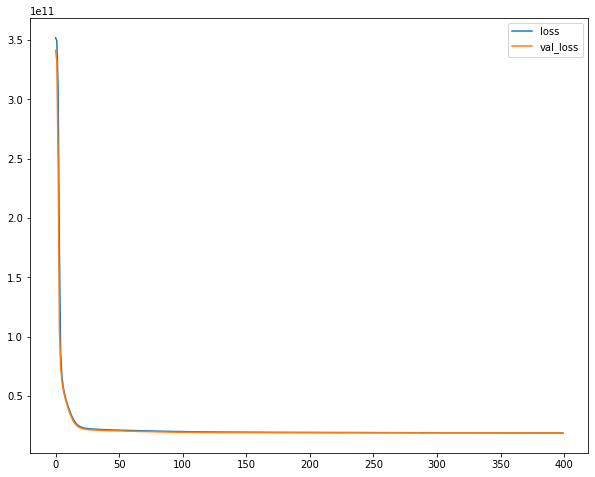

In [32]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Initially the loss is extremely high for both training and validation sets.. but as we run multiple iterations, both the losses decrease and become constant!

### Evaluation on Test Data

In [33]:
predictions = model.predict(X_test)

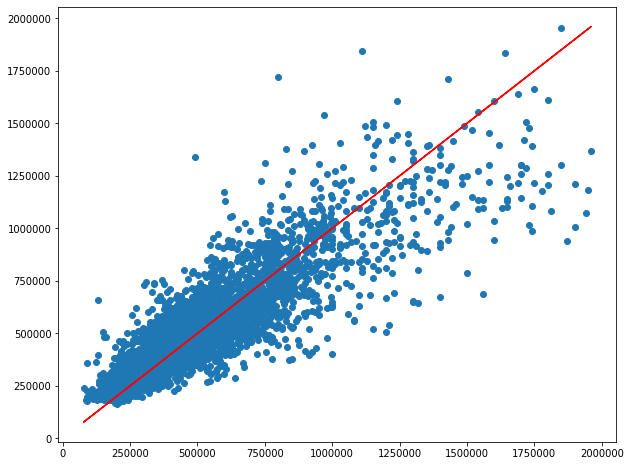

In [34]:
# Our predictions
plt.scatter(y_test, predictions)
# Perfect predictions
plt.plot(y_test, y_test,'r')

In [35]:
from sklearn.metrics import mean_squared_error, explained_variance_score

In [36]:
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print('RMSE: {}'.format(rmse))

RMSE: 136758.1253876044


In [37]:
explained_variance_score(y_test,predictions)

0.75822688710506

75% variance is not that bad.. ofcourse this could only be used when comparing different ML models...

### Predicting on a brand new house

In [38]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_old',
       'renovated_or_not', 'sale_yr'],
      dtype='object')

In [39]:
features = [3, 2, 120, 0, 3, 0, 1, 0, 0, 0, 20, 47.5112,-122.2570, 120, 0, 5, 0, 2019]

In [40]:
scaled_f = scaler.transform(np.array(features).reshape(-1, 18))

In [41]:
scaled_f

array([[-0.39376943, -0.13646291, -2.23957406, -0.37281163,  2.79654223,
        -0.07512924,  1.06587901, -5.2454047 , -6.71335529, -2.22798102,
        -0.61459435, -0.34904801, -0.30857187, -2.77548713, -0.46178519,
        -1.50250406, -0.14951606, 10.03834347]])

In [42]:
price = model.predict(scaled_f)
print('Your model house with above features will cost {} $'.format(round(price[0][0],2)))

Your model house with above features will cost 1179569.5 $
